# load DAS data and make some plots

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from xhistogram.xarray import histogram
#import dashydro.hydro as hy

---

## load data

In [2]:
root_data_dir = "/Users/aponte/Cloud/Dropbox/Public/das"
zarr = os.path.join(root_data_dir, "das/DAST_Toulon_July2019_strain.zarr")

In [3]:
ds = xr.open_zarr(zarr)

In [4]:
dt = float((ds.time[1]-ds.time[0])/pd.Timedelta("1T"))
print(f"Time sampling : dt = {dt} min")

Time sampling : dt = 2.0 min


---

## global perspective

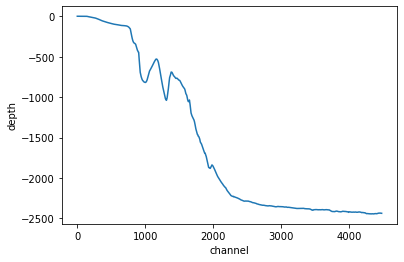

In [21]:
(-ds.depth).plot()

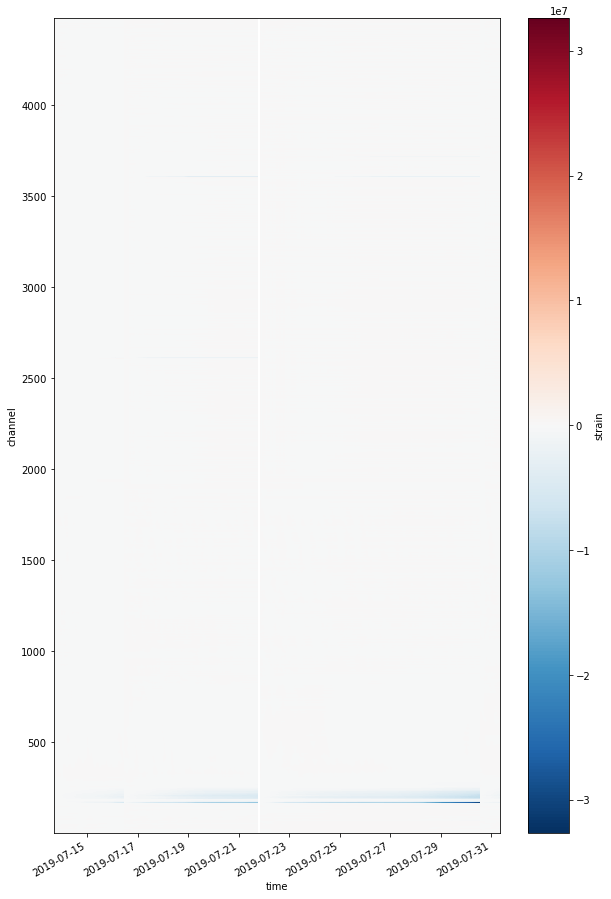

In [5]:
_da = ds.strain.isel(time=slice(0,None,15))
_da.plot()
#np.log10(_da).plot(figsize=(10,10))

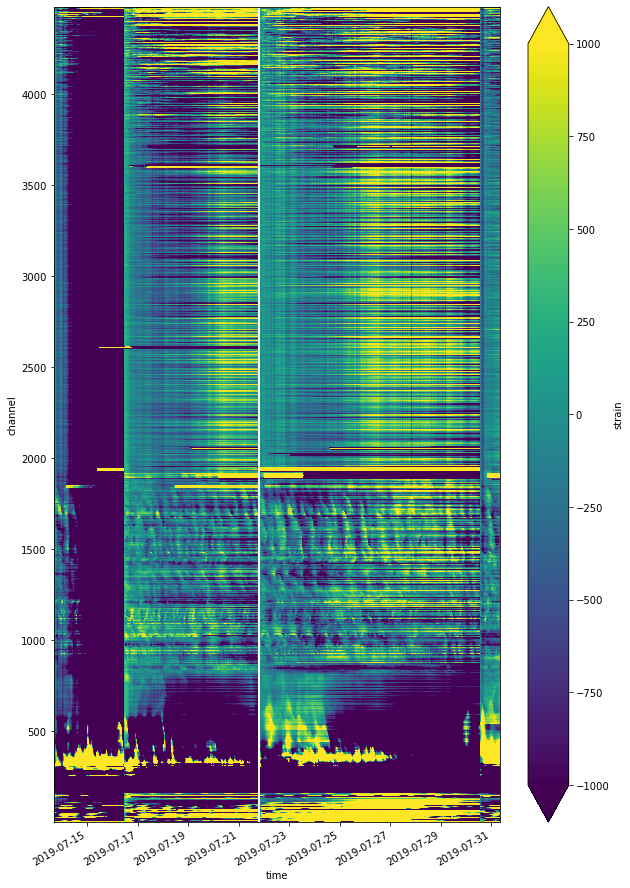

In [6]:
_da = ds.strain.isel(time=slice(0,None,15))
_da.plot(vmin=-1e3, vmax=1e3, figsize=(10,15))
#np.log10(_da).plot(figsize=(10,10))

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


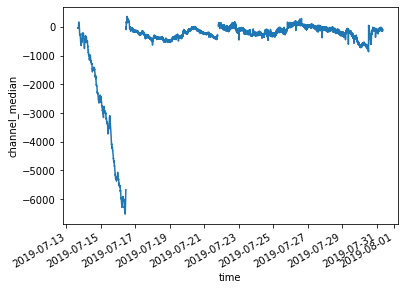

In [7]:
ds["channel_median"] = ds.strain.median("channel")
ds["channel_median"].plot()

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


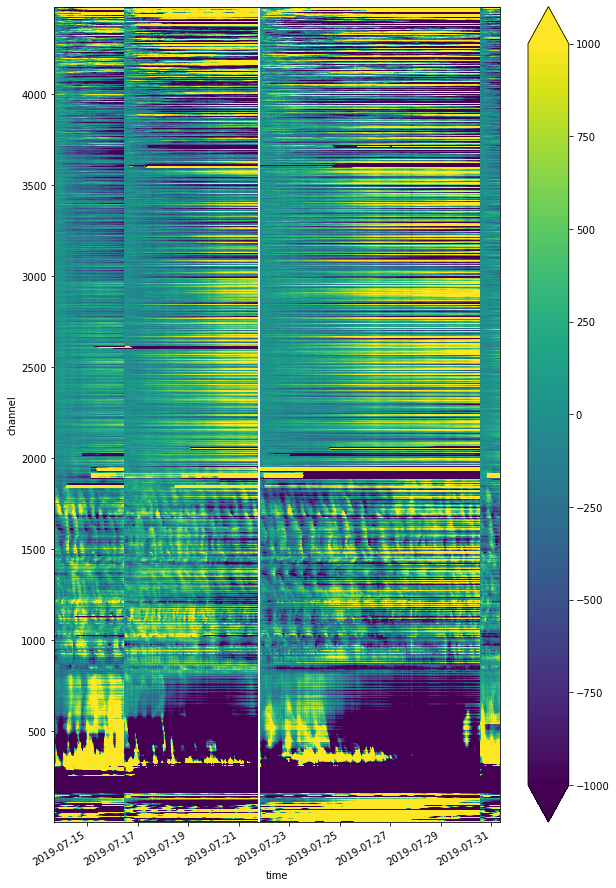

In [8]:
_da = (ds.strain - ds.channel_median).isel(time=slice(0,None,15))
_da.plot(vmin=-1e3, vmax=1e3, figsize=(10,15))

In [9]:
# removes and fill steps
_da = (ds.strain - ds.channel_median).fillna(0.).diff("time")
_da = _da.where(np.abs(_da)<200, other=0).cumsum("time")

ds["strain_nostep"] = _da

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


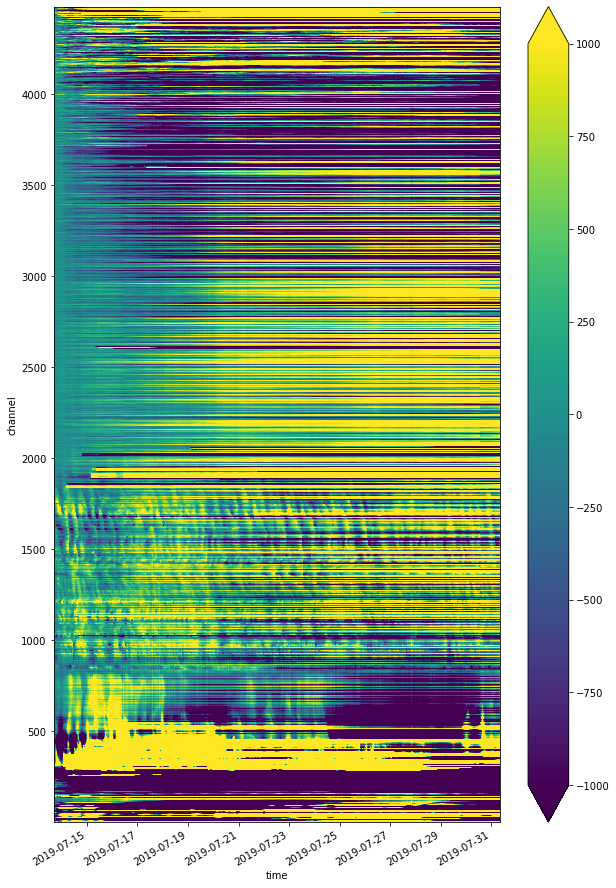

In [10]:
_da.isel(time=slice(0,None,15)).plot(vmin=-1e3, vmax=1e3, figsize=(10,15))

In [14]:
_da = ds.strain_nostep.resample(time="2D").mean()
ds["strain_low"] = _da.interp(time=ds.time)

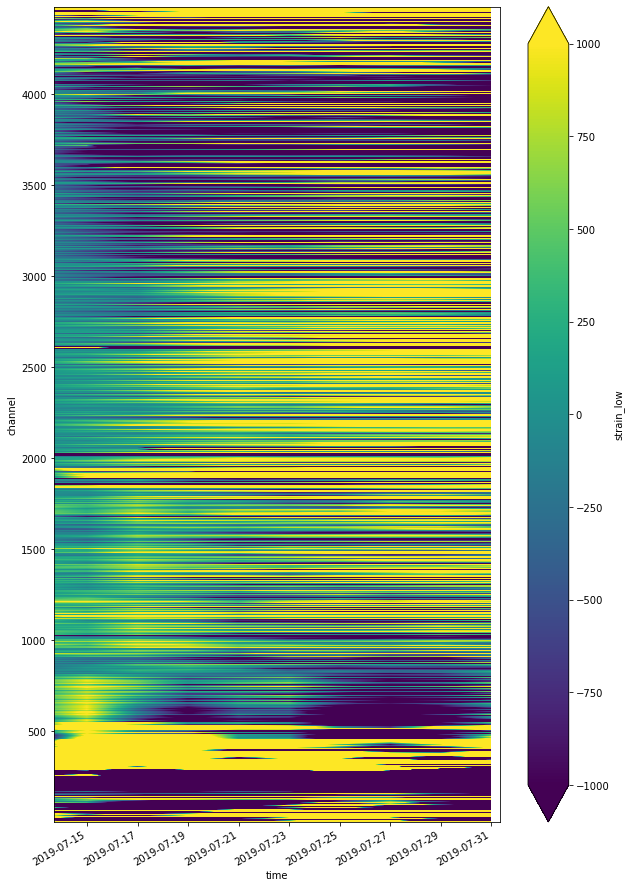

In [16]:
_da = ds.strain_low
_da.isel(time=slice(0,None,15)).plot(vmin=-1e3, vmax=1e3, figsize=(10,15))

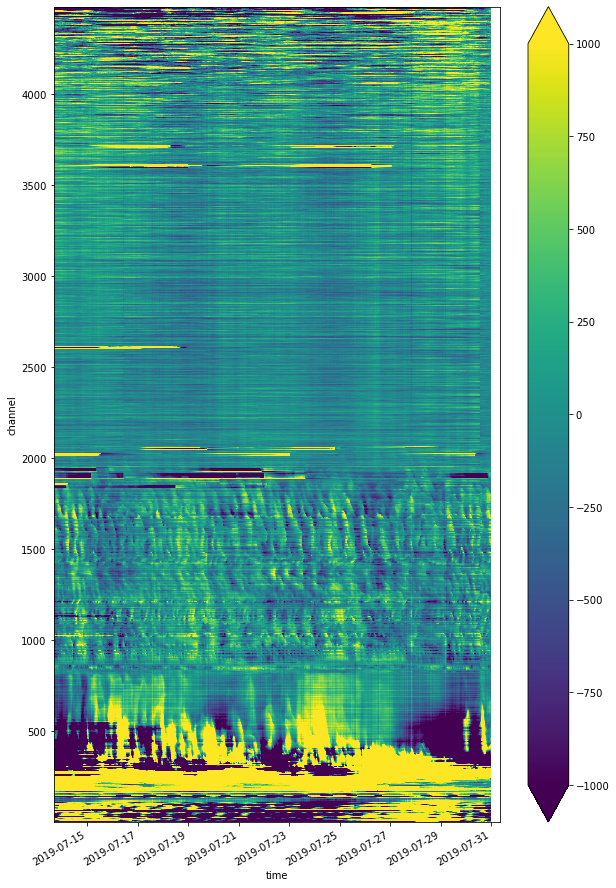

In [29]:
ds["strain_clean"] = ds.strain_nostep - ds.strain_low
_da.isel(time=slice(0,None,15)).plot(vmin=-1e3, vmax=1e3, figsize=(10,15))

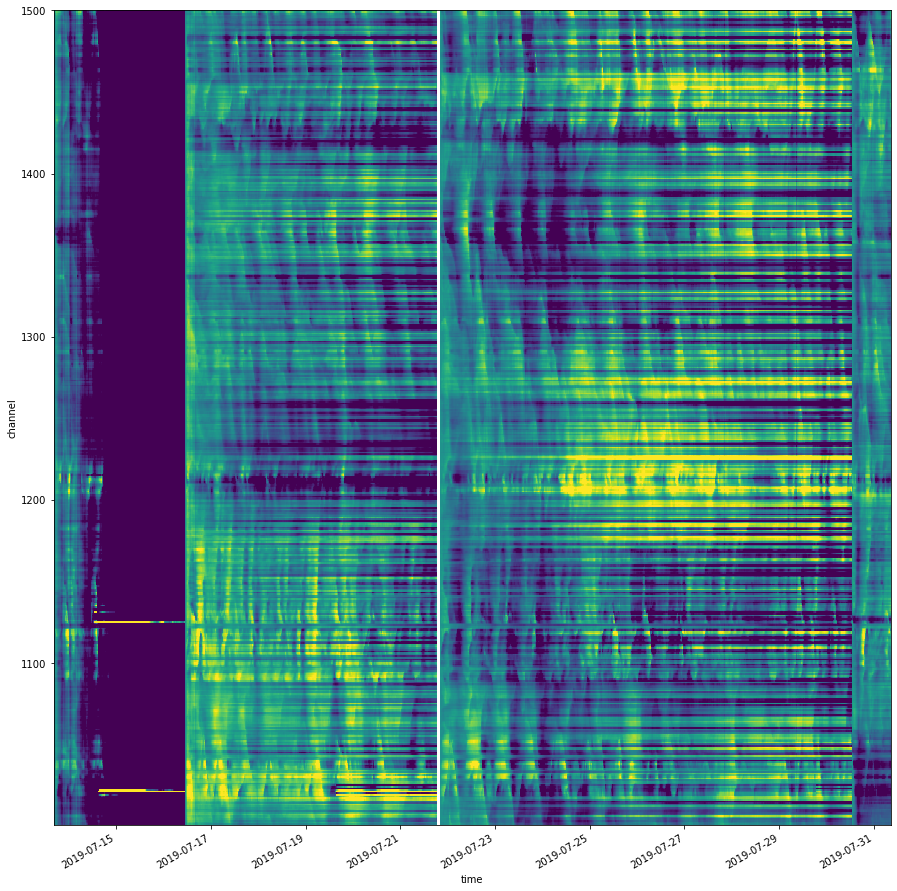

--- 

## Histogram of time rate of change and channel rate of change

In [30]:
dstrain_dt = ds.strain.diff("time").rename("d(strain)/dt")
dstrain_dc = ds.strain_clean.diff("channel").rename("d(strain)/dc")
h_t = histogram(dstrain_dt, dim=["time"], bins=np.arange(-100,100,1), density=True)
h_c = histogram(dstrain_dc, dim=["channel"], bins=np.arange(-1000,1000,10), density=True)

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


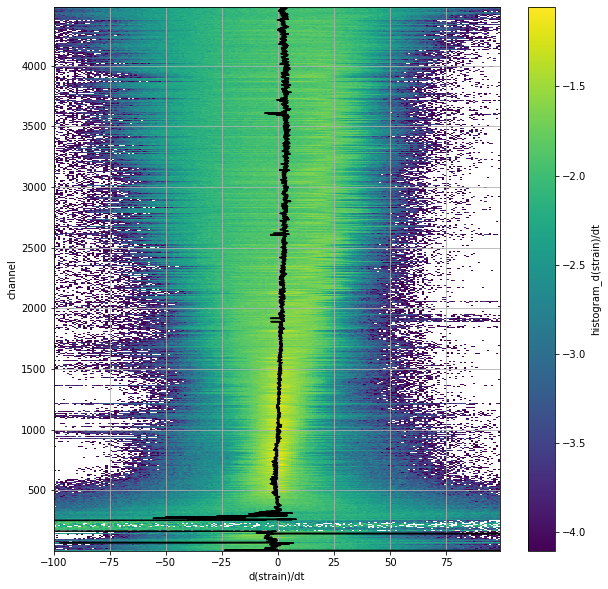

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
np.log10(h_t).plot()
dstrain_dt.median("time").plot(y="channel", color="k")
ax.grid()

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


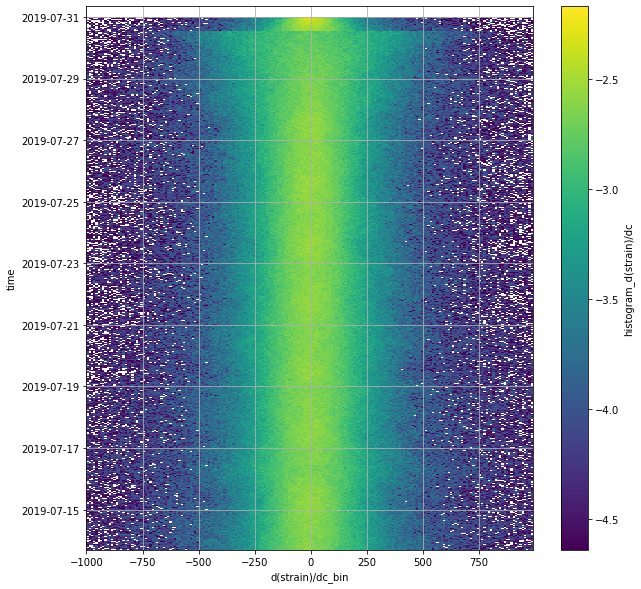

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
np.log10(h_c).plot()
#dstrain_dt.median("time").plot(y="channel", color="k")
ax.grid()

---
## zoom

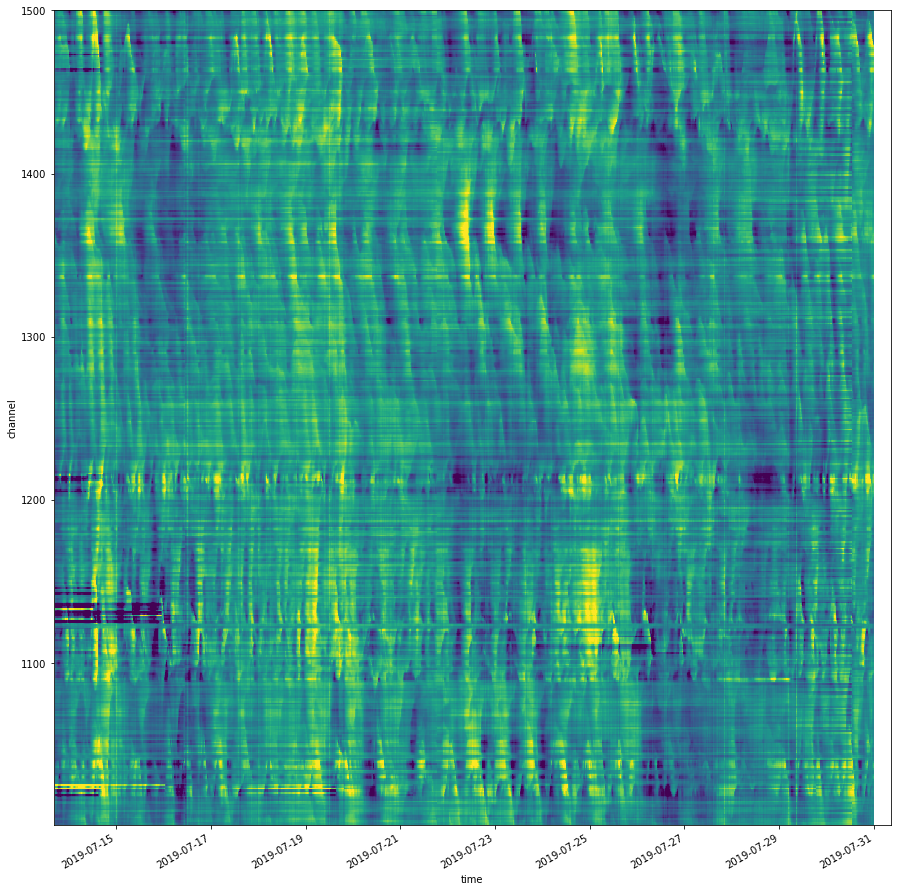

In [34]:
_da = ds.strain_clean.isel(time=slice(0,None,15), channel=slice(1000,1500))
_da.plot(vmin=-1e3, vmax=1e3, figsize=(15,15), add_colorbar=False)
#np.log10(_da).plot(figsize=(10,10))

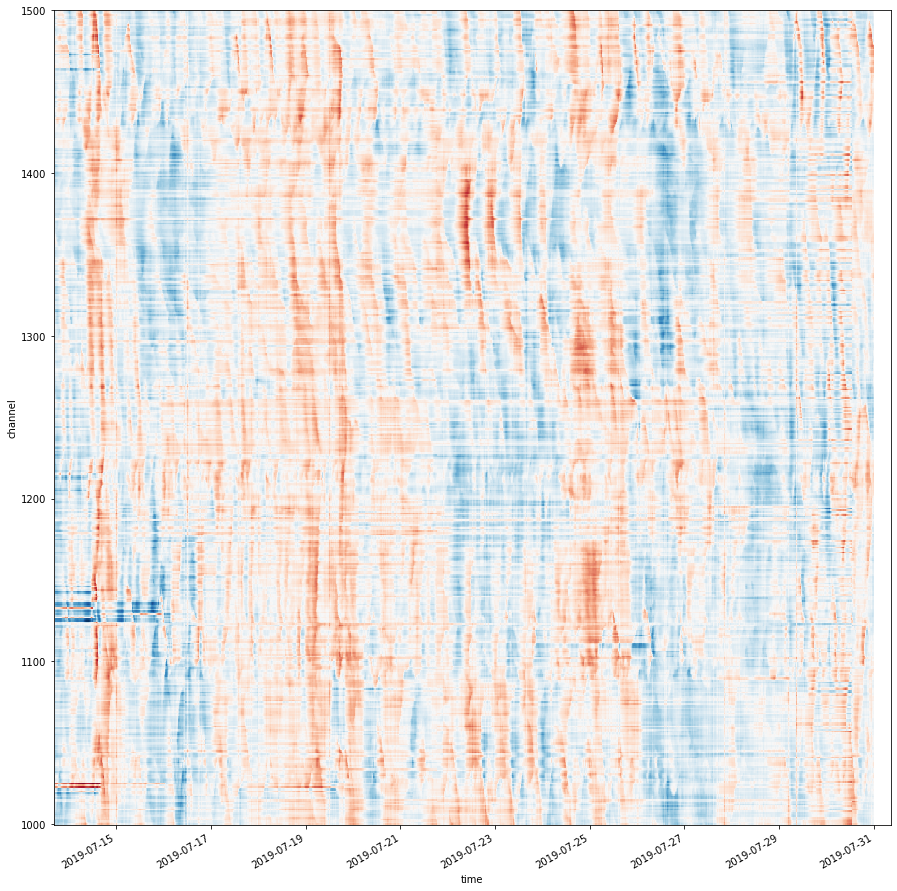

In [45]:
_da = ds.strain_clean.sel(channel=slice(1000,1500))
_da = _da/np.sqrt((_da**2).median("time"))
_da = _da.isel(time=slice(0,None,15))

_da.plot(figsize=(15,15), add_colorbar=False)